In [15]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./introduction.ipynb'))))

There are four cases
- Single treatment, single outcomes
- Single treatment, multiple outcomes
- Multiple treatments, single outcome
- Multiple treatments, multiple outcomes

In [17]:
import numpy as np
from numpy.random import multivariate_normal
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt

from ylearn.estimator_model import SLearner, TLearner, XLearner
from ylearn.estimator_model import DoublyRobust
from ylearn.exp_dataset.exp_data import binary_data
from ylearn.utils import to_df
%matplotlib inline

In [3]:
treatment_effect = lambda x: (1 if x[1] > 0.1 else 0) * 8

d = 5
n = 2500
n_test = 250

w_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6 / n_test
w_test[:, 1] = np.arange(-3, 3, delta)

In [4]:
y, x, w = binary_data(n=n, d=d, n_test=n_test)
data = to_df(outcome=y, treatment=x, w=w)
outcome = 'outcome'
treatment = 'treatment'
adjustment = data.columns[2:]
test_data = to_df(w=w_test)


## SLearner

In [5]:
s = SLearner(model=GradientBoostingRegressor())
s.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
)
s_pred = s.estimate(data=test_data, quantity=None)

In [6]:
s1 = SLearner(model=GradientBoostingRegressor())
s1.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
    combined_treatment=False
)
s1_pred = s1.estimate(data=test_data, quantity=None)

## TLearner

In [7]:
t = TLearner(
    model=GradientBoostingRegressor()
)
t.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
)
t_pred = t.estimate(data=test_data, quantity=None)

In [8]:
t1 = TLearner(
    model=GradientBoostingRegressor()
)
t1.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
    combined_treatment=False,
)
t1_pred = t1.estimate(data=test_data, quantity=None)

## XLearner

In [9]:
x = XLearner(
    model=GradientBoostingRegressor()
)
x.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
)
x_pred = x.estimate(data=test_data, quantity=None)

In [10]:
x1 = XLearner(
    model=GradientBoostingRegressor()
)
x1.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
    combined_treatment=False,
)
x1_pred = x1.estimate(data=test_data, quantity=None)

## DoublyRobust Model

In [11]:
dr = DoublyRobust(
    x_model=RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_leaf=int(n/100)),
    y_model=GradientBoostingRegressor(n_estimators=100, max_depth=100, min_samples_leaf=int(n/100)),
    yx_model=GradientBoostingRegressor(n_estimators=100, max_depth=100, min_samples_leaf=int(n/100)),
    cf_fold=1,
    random_state=2022,
)
dr.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    covariate=adjustment,
)
dr_pred = dr.estimate(data=test_data, quantity=None).squeeze()

### Result for MetaLearners when combined_treatment=True

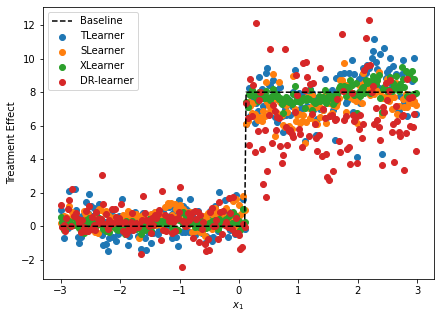

In [12]:
plt.figure(figsize=(7, 5))
plt.plot(w_test[:, 1], np.apply_along_axis(treatment_effect, 1, w_test), color='black', ls='--', label='Baseline')
plt.scatter(w_test[:, 1], t_pred, label="TLearner")
plt.scatter(w_test[:, 1], s_pred, label="SLearner")
plt.scatter(w_test[:, 1], x_pred, label="XLearner")
plt.scatter(w_test[:, 1], dr_pred, label="DR-learner")
# plt.ylim(-5, 13)
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

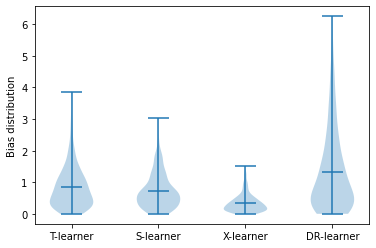

In [13]:
expected_te = np.apply_along_axis(treatment_effect, 1, w_test)
plt.violinplot([np.abs(t_pred - expected_te), 
                np.abs(s_pred - expected_te),
                np.abs(x_pred - expected_te),
                np.abs(dr_pred - expected_te)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3, 4,], ['T-learner', 'S-learner', 'X-learner', 'DR-learner'])
plt.show()

### Result for MetaLearners when combined_treatment=False

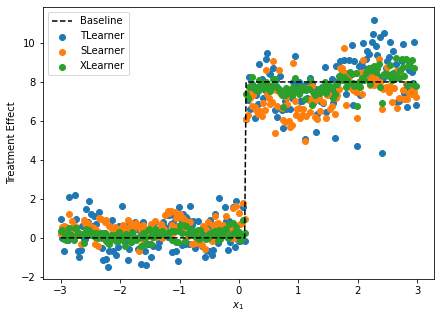

In [14]:
plt.figure(figsize=(7, 5))
plt.plot(w_test[:, 1], np.apply_along_axis(treatment_effect, 1, w_test), color='black', ls='--', label='Baseline')
plt.scatter(w_test[:, 1], t1_pred, label="TLearner")
plt.scatter(w_test[:, 1], s1_pred, label="SLearner")
plt.scatter(w_test[:, 1], x1_pred, label="XLearner")
# plt.scatter(w_test[:, 1], dr_pred, label="DR-learner")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()